# Low-thrust transfers via indirect methods IV (time, mean equinoctial elements)

In this notebook we show how to solve the **minimum time** Optimal Control Problem (OCP) for a low-thrust interplanetary transfer employing an indirect method and using 

Indirect methods follow rather mechanic developments: starting from the dynamics a TPBVP (Two-Point-Boundary-Value-Problem) is built applying Pontryagin maximum (minimum, in our case) principle (PMP). The TPBVP is defined on an augmented ODE system and solved by means of single or multiple shooting methods.

In this notebook we guide, step-by-step, the reader in the application of such a method in a widely encountered case in space flight mechanics. Eventually use `pykep` native tools to quickly skip the tedious parts.

In [1]:
import pykep as pk
import numpy as np
import heyoka as hy
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

## Manual construction of the TPBVP
We consider the motion of a spacecraft of mass $m$ with a position $\mathbf{r}$ and velocity $\mathbf{v}$ subject only to the Sun's gravitational attraction in some inertial reference frame. The spacecraft also has an ion thruster with a specific impulse $I_{sp}$ and a maximum thrust $T_{max} = c_1$ independent from solar distance.
We describe the spacecraft state via its mass $m$ and the (prograde) modified equinoctial elements $\mathbf{x}=\left[p,f,g,h,k,L\right]^T$ (See the [Elements page](../elements.rst) for their exact definition within `pykep`).


$$
\begin{array}{l}
\dot p = \sqrt{\frac p\mu} \frac{2p}{w} i_t \cdot c_1 \frac um \\
\dot f = \sqrt{\frac p\mu} \left\{i_r \sin L + \left[ (1+w)\cos L + f \right] \frac{i_t}{w} - (h\sin L-k\cos L)\frac{g\cdot i_n}{w} \right\} \cdot c_1\frac um \\
\dot g = \sqrt{\frac p\mu} \left\{ - i_r\cos L + \left[ (1+w)\sin L + g \right] \frac{i_t}{w} + (h\sin L-k\cos L)\frac{f\cdot i_n}{w} \right\} \cdot c_1\frac um \\
\dot h = \sqrt{\frac p\mu} \frac{s^2i_n}{2w}\cos L \cdot c_1\frac um \\
\dot k = \sqrt{\frac p\mu} \frac{s^2i_n}{2w}\sin L \cdot c_1\frac um \\
\dot L = \sqrt{\frac p\mu}\left\{\mu\left(\frac wp\right)^2 + \frac 1w\left(h\sin L-k\cos L\right) i_n\cdot c_1\frac um \right\} \\
\dot m = - \frac{c_1}{c_2} \cdot u \\
\end{array}
$$

where, $w = 1 + f\cos L + g\sin L$, $s^2 = 1 + h^2 + k^2$ and $\hat{\mathbf i}_\tau = [i_r, i_t, i_n]$ are the radial, tangential and normal components of thrust direction, while $u \in [0,1]$ is the throttle. As in the Cartesian case, $T_{max}=c_1$ and $I_{sp}g_0 = c_2$. The gravitational parameter is denoted with $\mu$. We can rewrite the above equations in a more compact form:

$$
\left\{
\begin{array}{l}
\dot {\mathbf x} =  \frac {c_1 u(t)} m \mathbf B(\mathbf x)  \mathbf{\hat i_\tau}  + \mathbf D(\mathbf x) \\
\dot m = -c_2 u(t)
\end{array}
\right.
$$

where:

$$
\sqrt{\frac \mu p} \mathbf B(\mathbf x) = 
\left[
\begin{array}{ccc}
0 & \frac {2p}w & 0 \\
 \sin L & [(1+w)\cos L + f]\frac 1w  & - \frac gw (h\sin L-k\cos L)  \\
- \cos L & [(1+w)\sin L + g]\frac 1w  & \frac fw (h\sin L-k\cos L) \\
0 & 0  & \frac 1w \frac{s^2}{2}\cos L \\
0 & 0  & \frac 1w \frac{s^2}{2}\sin L \\
0 & 0  & \frac 1w (h\sin L - k\cos L) \\
\end{array}
\right]
$$

and:

$$
\mathbf D(\mathbf x) = 
\left[
\begin{array}{cccccc}
0 & 0 & 0 & 0 & 0 & \sqrt{\frac{\mu}{p^3}}w^2
\end{array}
\right]^T
$$

Let us use `heyoka` to work with the above equations. We will use the `heyoka` library to define the state variables, the control and the time variable.
We also introduce as many auxiliary functions $\mathbf \lambda$ (the co-states) are there are state variables. 

In [2]:
# The state
p, f, g, h, k, L, m = hy.make_vars("p", "f", "g", "h", "k", "L", "m")
# The costate
lp, lf, lg, lh, lk, lL, lm = hy.make_vars(
    "lp", "lf", "lg", "lh", "lk", "lL", "lm"
)
# The controls
u, i_r, i_t, i_n = hy.make_vars("u", "ir", "it", "in")

As to write comfortably the various developments, we introduce some useful expressions and regroup some of our variable into 3D vectors:

In [3]:
# Useful expressions
w = 1 + f * hy.cos(L) + g * hy.sin(L)
s2 = 1 + h * h + k * k
B = np.array(
    [
        [0, 2 * p / w, 0.0],
        [
            hy.sin(L),
            ((1 + w) * hy.cos(L) + f) / w,
            -g / w * (h * hy.sin(L) - k * hy.cos(L)),
        ],
        [
            -hy.cos(L),
            ((1 + w) * hy.sin(L) + g) / w,
            f / w * (h * hy.sin(L) - k * hy.cos(L)),
        ],
        [0, 0, s2 / w / 2.0 * hy.cos(L)],
        [0, 0, s2 / w / 2.0 * hy.sin(L)],
        [0, 0, 1.0 / w * (h * hy.sin(L) - k * hy.cos(L))],
    ]
) * hy.sqrt(p / hy.par[0])

D = np.array([0.0, 0.0, 0.0, 0.0, 0.0, hy.sqrt(hy.par[0] / p / p / p) * w * w])

i_vers = np.array([i_r, i_t, i_n])
lx = np.array([lp, lf, lg, lh, lk, lL])

The dynamics can then be written as:

In [4]:
# Dynamics
fx = np.dot(B, i_vers) * u * hy.par[1] / m + D
fm = - hy.par[1] / hy.par[2] * u

We introduce the Hamiltonian ($\mathbf x$ is the whole state, $\mathbf \lambda$ is the whole co-state, and $\mathbf u$ represent are all the controls), 

$$
\mathcal H(\mathbf x, \mathbf \lambda, \mathbf u) = \mathbf \lambda_x \cdot \mathbf f_x + \lambda_m  f_m + \lambda_0 \frac {c_1}{c_2}
$$

In [5]:
# Hamiltonian
H_full = (lx @ fx + lm * fm + hy.par[4] * hy.par[1] / hy.par[2])
# Switching function (this must be found by hand)
BTlam = B.T@lx 
BTlam_norm = hy.sqrt(BTlam @ BTlam)
rho = - hy.par[2] * BTlam_norm / m / hy.par[4] - lm / hy.par[4]

Note how the various constants of our problem are considered as heyoka parameters in the following order: $[\mu, c_1, c_2, \epsilon, \lambda_0]$, $c_1 = T_{max}$, $c_2 = v_{eff}$. It is to be noted here that the continuation parameter $\epsilon$ is actually not in here and that also $\lambda_0$ plays no role in the dynamics.

And write the resulting Hamiltonian system:

$$
\left\{
\begin{array}{l}
\dot{\mathbf x} = \frac{\partial \mathcal H}{\partial \mathbf \lambda} \\
\dot{\mathbf \lambda} = - \frac{\partial \mathcal H}{\partial \mathbf x} \\
\end{array}\right.
$$

In [6]:
# Augmented equations of motion
rhs = [
    hy.diff(H_full, var)
    for var in [lp, lf, lg, lh, lk, lL, lm, p, f, g, h, k, L, m]
]
for j in range(7, 14):
    rhs[j] = -rhs[j]

The minimum principle from Pontryagin requires to find the mimimum in the admissible control space of the Hamiltonian:

$$
\mathbf u^* = \argmin_{\mathbf u \in \mathcal U} \mathcal H(\mathbf x, \mathbf \lambda, \mathbf u)
$$

which, in our case, results in:

In [7]:
# We apply Pontryagin minimum principle (primer vector and u^* = 2eps / (rho + 2eps + sqrt(rho^2+4*eps^2)))
argmin_H_full = {
    i_r: -BTlam[0] / BTlam_norm,
    i_t: -BTlam[1] / BTlam_norm,
    i_n: -BTlam[2] / BTlam_norm,
    u: hy.expression(1.)
}

Thanks to the above relations, the control is now a continuous differentiable function of the states and costates and thus the dynamics as well as the Hamiltonian can be reworked: 

In [8]:
rhs = hy.subs(rhs, argmin_H_full)

# We also build the Hamiltonian as a function of the state / co-state only
# (i.e. no longer of controls now solved thanks to the minimum principle)
H = hy.subs(H_full, argmin_H_full)

The following code block thus instantiate the heyoka integrator as well as other convenience functions.

In [9]:
# We compile the Hamiltonian into a C function (to be called with pars = [mu, c1, c2, eps, l0], but epsilon does not really matter)
H_func = hy.cfunc([H], [p, f, g, h, k, L, m , lp, lf, lg, lh, lk, lL, lm ])
# We compile the thrust direction
u_func = hy.cfunc(
    [argmin_H_full[u]], [p, f, g, h, k, L, m , lp, lf, lg, lh, lk, lL, lm ]
)
# We compile the SF
rho_func = hy.cfunc([rho], [p, f, g, h, k, L, m , lp, lf, lg, lh, lk, lL, lm ])
# We compile also the thrust direction
i_vers_func = hy.cfunc(
    [argmin_H_full[i_r], argmin_H_full[i_t], argmin_H_full[i_n]], [p, f, g, h, k, L, m , lp, lf, lg, lh, lk, lL, lm ]
)
# We assemble the Taylor adaptive integrator
full_state = [p, f, g, h, k, L, m , lp, lf, lg, lh, lk, lL, lm ]
sys = [(var, dvar) for var, dvar in zip(full_state, rhs)]
ta = hy.taylor_adaptive(sys, state=[1.0] * 14, compact_mode=True)

In [10]:
# note that the dynamics does not depend on hy.par[4] so all those equations will be zero. 
# we nevertheless use hy.par[4] for consistency with the mass optimal case which can be handy.
var_sys = hy.var_ode_sys(sys, args = [lp,lf,lg,lh,lk,lL,lm, hy.par[4]])
ta_var = hy.taylor_adaptive(var_sys, compact_mode=True)

## Constructing the TPBVP using pykep

For the specific case outlined above pykep offers a convenient series of pre-assembled functions and objects which basically construct the same objects as above. 

These can turn out to be useful or analysis of specific cases, but in general they are used internally by various UDP provided in `pykep` hence the user in most cases does not need to care.

In [11]:
# The Taylor integrator
ta = pk.ta.get_peq(1e-16, pk.optimality_type.TIME)
# The Variational Taylor integrator
ta_var = pk.ta.get_peq_var(1e-16, pk.optimality_type.TIME)
# The Hamiltonian
H_func = pk.ta.get_peq_H_cfunc(pk.optimality_type.TIME)
# The switching function
SF_func = pk.ta.get_peq_SF_cfunc(pk.optimality_type.TIME)
# The magnitude of the throttle
u_func = pk.ta.get_peq_u_cfunc(pk.optimality_type.TIME)
# The thrust direction
i_vers_func = pk.ta.get_peq_i_vers_cfunc(pk.optimality_type.TIME)
# The dynamics cfunc
dyn_func = pk.ta.get_peq_dyn_cfunc(pk.optimality_type.TIME)

## Solving in single shooting

All the code above was merely showed for tutorial purposes. 

Now we scratch all of that and use dedicated `pykep` clsses to construct, based on the TPVP described in detail above, a shoting problem.

We use, as a test case, the very same simple transfer used in a previous [notebook on the mass optimal](<./pontryagin_equinoctial_mass.ipynb>). The transfer is simple enough to allow fast convergence.

In [12]:
# Testcase 1 
source=pk.planet(pk.udpla.jpl_lp("earth"))
target=pk.planet(pk.udpla.jpl_lp("mars"))

tof_guess = 250
mu = pk.MU_SUN
eps = 1e-5
T_max = 6.
Isp = 3000
m0 = 1500
n_rev=0

We instantiate the shooting method using the UDP provided by `pykep`:

In [ ]:
# Factory for the pygmo udp.
def prob_factory(T_max, tof_guess):
    udp = pk.trajopt.pontryagin_equinoctial_time(
        source=source,
        target=target,
        tof_guess=tof_guess,
        t0 = pk.epoch(400),
        lambda0 = None,  # We normalize the costates
        T_max=T_max,
        veff=3000*pk.G0,
        m0=1500,
        n_rev=0,
        L=pk.AU,
        MU=pk.MU_SUN,
        MASS=1500,
        with_gradient=True,
        taylor_tolerance=1e-10, # lower tolerance for the Taylor integrator since the problem is easy
        taylor_tolerance_var=1e-10
    )
    udp.ta = ta
    prob = pg.problem(udp)
    prob.c_tol = 1e-6
    return prob

prob = prob_factory(0.6, 250)
sparsity = prob.gradient_sparsity()
udp = prob.extract(pk.trajopt.pontryagin_equinoctial_time)

To solve this problem, we can use SPQ methods, interior point methods as well as root finders. In this notebook, we make use of the widely available IPOPT interior-point method and of the minpack routines. Both are open-source initiatives and require no license.

IPOPT is natively available in pagmo, thus we can instantiate it as:

In [22]:
ip = pg.ipopt()
ip.set_numeric_option("tol", 1e-9)  # Change the relative convergence tolerance
ip.set_integer_option("max_iter", 50)  # Change the maximum iterations
ip.set_integer_option("print_level", 0)  # Makes Ipopt unverbose
ip.set_string_option(
    "nlp_scaling_method", "none"
)  # Removes any scaling made in auto mode
ip.set_string_option(
    "mu_strategy", "adaptive"
)  # Alternative is to tune the initial mu value
ipopt = pg.algorithm(ip)

MINPACK is available via scipy and is missing in the current pygmo version, but we can quickly provide a wrapper as a UDA:

In [23]:
class my_solver:
    def __init__(self, gradient):
        self.gradient = gradient
    def evolve(self, pop: pg.population):
        from scipy.optimize import root
        prob = pop.problem
        x0 = pop.champion_x
        n = prob.get_nx()
        if self.gradient:
            def dense_grad(x):
                G = np.zeros((n,n))
                G[sparsity[:, 0], sparsity[:, 1]] = prob.gradient(x)
                return G.reshape(n,n)
            res = root(lambda x: [0] +  list(prob.fitness(x)[1:]), x0, method="hybr", tol=1e-8, options = {"factor": 1., "diag": [1]*(n)}, jac=dense_grad)  # factor=1 is very important for convergence
        else:
            res = root(lambda x: [0] +  list(prob.fitness(x)[1:]), x0, method="hybr", tol=1e-8, options = {"factor": 1., "diag": [1]*(n)})  # factor=1 is very important for convergence
        pop.set_x(0, res["x"])
        return pop
    def get_name(self):
        return "Minpack hybrd routine"

minpack = pg.algorithm(my_solver(False))
minpack_g = pg.algorithm(my_solver(True))

To solve the problem here we use a multi-start teachnique, since this is in general a good practice. In this specific case convergence is immediate and multiple starts are not strictly necessary.

In [24]:
def multistart(algo, n_trials=50):
    masses = []
    xs = []
    total_time = 0.0
    success=0

    for i in range(n_trials):
        pop = pg.population(prob,1)
        time_start = time.time()
        pop = algo.evolve(pop)
        time_end = time.time()
        total_time += time_end - time_start
        if prob.feasibility_f(pop.champion_f):
            print(".", end="")
            udp.fitness(pop.champion_x)
            xs.append(pop.champion_x)
            masses.append(udp.ta.state[6])
            success+=1
        else:
            print("x", end="")
    if masses:
        print(f"\nFinal mass is: {masses[0]*udp.MASS}")
        print(f"Total time to success: {total_time:.3f} seconds")
        print(f"Number of successes: {success} over {n_trials} trials ({success/n_trials*100:.1f} %)")
    else:
        print("\nNo success")
    return pop

In [25]:
pop = multistart(ipopt, n_trials=10)

...x.....x
Final mass is: 1049.4338611857288
Total time to success: 12.165 seconds
Number of successes: 8 over 10 trials (80.0 %)


In [27]:
pop = multistart(minpack_g, n_trials=10)

...x......
Final mass is: 1049.43386119149
Total time to success: 2.154 seconds
Number of successes: 9 over 10 trials (90.0 %)


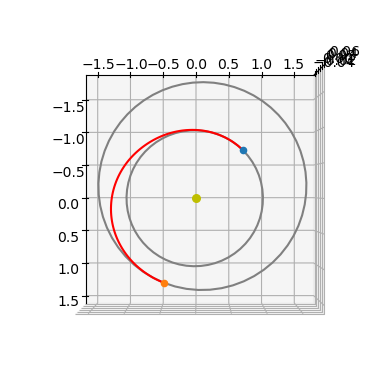

In [19]:
ax = udp.plot(pop.champion_x)
ax.view_init(90,0)


Thrust arcs are indicated with a red color, ballistic with blue.

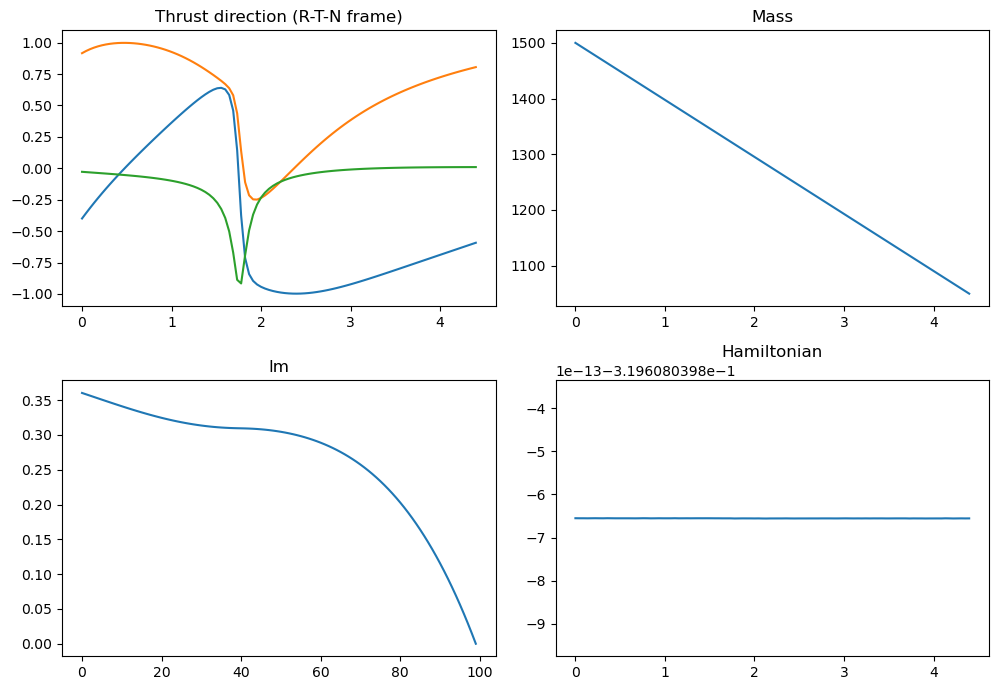

In [20]:
udp.plot_misc(pop.champion_x);